In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os,glob
import numpy as np
import cv2
import glob
import pickle
import tensorflow as tf
import argparse
import re
import datetime
from skimage.transform import rescale, resize, downscale_local_mean
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms,models
import numpy as np
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from numpy import loadtxt
from PIL import Image
from tqdm import tqdm

In [ ]:
from sklearn.model_selection import train_test_split

positives = "/content/drive/MyDrive/Datasets/static_dataset/StaticA"
negatives = "/content/drive/MyDrive/Datasets/static_dataset/StaticN"

positives = np.array(glob.glob(positives + "/*.jpg"))
negatives = np.array(glob.glob(negatives + "/*.jpg"))

print(len(positives))
print(len(negatives))

train_images = []
train_labels = []
test_images = []
test_labels = []

training_positive, testing_positive = train_test_split(positives, test_size=0.2, random_state=42)
training_negative, testing_negative = train_test_split(negatives, test_size=0.2, random_state=42)

print(len(training_positive))
print(len(testing_positive))
print(len(training_negative))
print(len(testing_negative))


for i in training_positive:
  img = Image.open(i)
  train_images.append(np.array(img))
  train_labels.append(1)

for i in testing_positive:
  img = Image.open(i)
  test_images.append(np.array(img))
  test_labels.append(1)

for i in training_negative:
  img = Image.open(i)
  train_images.append(np.array(img))
  train_labels.append(0)

for i in testing_negative:
  img = Image.open(i)
  test_images.append(np.array(img))
  test_labels.append(0)

print(len(train_images), len(train_labels))
print(len(test_images), len(test_labels))




124
132
99
25
105
27
204 204
52 52


In [ ]:
Image.open(positives[0])

In [ ]:
print(test_images[0])

In [ ]:
print(train_images[0].shape)



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
#pytorch dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #returns total number of images
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float)
        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((228, 228)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),  # Rotates images by up to 15 degrees
    transforms.RandomResizedCrop(size=(228, 228), scale=(0.8, 1.0)), # Randomly crops and resizes images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])

])


train_dataset = CustomDataset(images=train_images, labels=train_labels, transform=transform)
test_dataset = CustomDataset(images=test_images, labels=test_labels, transform=transform)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Data shape: torch.Size([1, 228, 228])
Labels shape: torch.Size([])


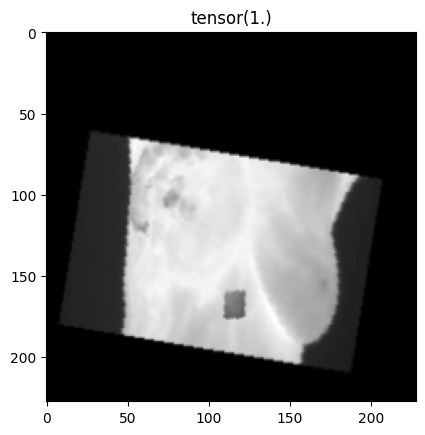

In [ ]:
data, labels = train_dataset[0]
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
plt.imshow(data.squeeze(), cmap='gray')
plt.title(labels)
plt.show()


In [ ]:
class BreastCancerCNN(nn.Module):
    def __init__(self):
        super(BreastCancerCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU()
            )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=256*3*3, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Softmax(dim=1)
            )

    def forward(self, x):
      x = self.conv_layers(x)
      x = x.view(x.size(0), -1)
      x = self.fc_layers(x)
      return x




In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)




cuda


In [ ]:
import torch.optim as optim

model = BreastCancerCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


x = data
y = labels
print(x.shape)
print(y.shape)

print((x.unsqueeze(0)).shape)
#print((y.unsqueeze(0)).shape)






torch.Size([1, 228, 228])
torch.Size([])
torch.Size([1, 1, 228, 228])


In [ ]:
epochs = 30

for epoch in range(epochs):
  model.train()
  y_true, y_pred = [],[]
  for x, y in test_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs[:, 0], y.float())
    loss.backward()
    optimizer.step()


In [ ]:
def calculate_sensitivity(y_pred, y_true):
    true_positives = 0
    false_negatives = 0
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred = y_pred[:, 0]
    for i in range(len(y_pred)):
      true_positives =  true_positives + ((y_pred[i] == 1) & (y_true[i] == 1))
      false_negatives = false_negatives + ((y_pred[i] == 0) & (y_true[i] == 1))

    # Calculate sensitivity
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

In [ ]:
def accuracy(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  y_pred = y_pred[:, 0]
  correct = (y_true == y_pred).sum().item()
  total = y_true.size
  return correct / total

model.eval()
y_true, y_pred = [],[]
with torch.no_grad():
  for x, y in test_dataloader:
    x, y = x.to(device), y.to(device)
    outputs = model(x)
    predictions = (outputs > 0.5).float()
    y_true.extend(y.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())
print(len(y_pred))
print(len(y_true))
print("Accuracy:", accuracy(y_true, y_pred))
print("Sensitivity:", calculate_sensitivity(y_pred, y_true))

In [ ]:
training_positive = "/content/drive/MyDrive/Datasets/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES"
training_negative = "/content/drive/MyDrive/Datasets/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDAΓòá├╝VEIS"

testing_positive = "/content/drive/MyDrive/Datasets/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES"
testing_negative ="/content/drive/MyDrive/Datasets/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/SAUDAΓòá├╝VEIS"

#np array of all train images,train labels,test images, test labels
train_images=[]
train_labels=[]
test_images = []
test_labels = []
#class 1 for positive and 0 for negative
for folder in os.listdir(training_positive):
  path = os.path.join(training_positive, folder , 'Segmentadas')
  for filename in os.listdir(path):
    if filename.endswith('.png'):
      img = Image.open(os.path.join(path, filename))
      train_images.append(np.array(img))
      train_labels.append(1)

for folder in os.listdir(training_negative):
  path = os.path.join(training_negative, folder , 'Segmentadas')
  for filename in os.listdir(path):
    if filename.endswith('.png'):
      img = Image.open(os.path.join(path, filename))
      train_images.append(np.array(img))
      train_labels.append(0)

for folder in os.listdir(testing_positive):
  path = os.path.join(testing_positive, folder , 'Segmentadas')
  for filename in os.listdir(path):
    if filename.endswith('.png'):
      img = Image.open(os.path.join(path, filename))
      test_images.append(np.array(img))
      test_labels.append(1)

for folder in os.listdir(testing_negative):
  path = os.path.join(testing_negative, folder , 'Segmentadas')
  for filename in os.listdir(path):
    if filename.endswith('.png'):
      img = Image.open(os.path.join(path, filename))
      test_images.append(np.array(img))
      test_labels.append(0)
train_labels=np.array(train_labels)
testing_labels = np.array(test_labels)
print(f" Number of train scans: {len(train_images)} \n train labels: {len(train_labels)} " )
print(f" Number of testing scans: {len(test_images)} \n test labels: {len(test_labels)} " )